In [1]:
import torch as t
t.cuda.is_available()

True

In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import numpy as np

In [3]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto')
X = X.values
y = y.astype(int).values

<Axes: >

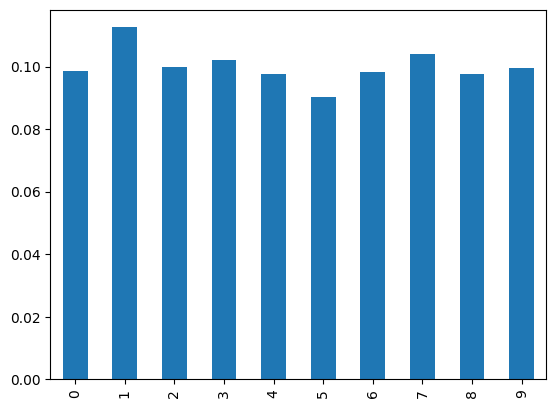

In [4]:
from collections import Counter
import pandas as pd
counter = Counter()
counter.update(y)
# e.g. 5 is slightly underrepresented
pd.DataFrame(sorted({item: count / len(y) for item, count in counter.items()}.items()))[1].plot.bar()

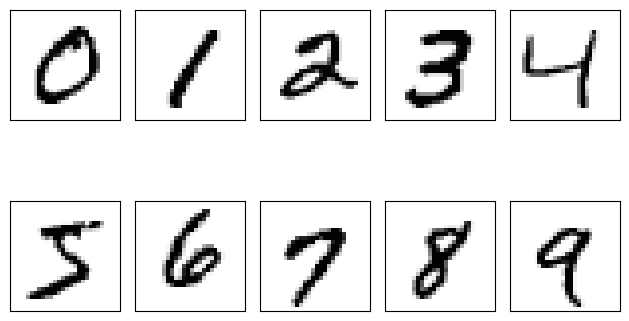

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_4.png', dpi=300)
plt.show()

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)
X

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

In [7]:
import torch as t
from sklearn.model_selection import train_test_split

# 80% train; 10% validation; 10% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

X_train = t.tensor(X_train, dtype=t.float32)
y_train = t.tensor(y_train, dtype=t.long)
X_val = t.tensor(X_val, dtype=t.float32)
y_val = t.tensor(y_val, dtype=t.long)
X_test = t.tensor(X_test, dtype=t.float32)
y_test = t.tensor(y_test, dtype=t.long)

print(f"Training set  : X-{X_train.shape}, y-{y_train.shape}")
print(f"Validation set: X-{X_val.shape}, y-{y_val.shape}")
print(f"Test set      : X-{X_test.shape}, y-{y_test.shape}")

Training set  : X-torch.Size([56000, 784]), y-torch.Size([56000])
Validation set: X-torch.Size([7000, 784]), y-torch.Size([7000])
Test set      : X-torch.Size([7000, 784]), y-torch.Size([7000])


In [8]:
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

class Model(nn.Module):
    def __init__(self, hidden_layers: list[int]):
        super(Model, self).__init__()
        # self.layer_1 = nn.Linear(28 * 28, 500)
        # self.layer_2 = nn.Linear(500, 10)
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(28 * 28, hidden_layers[0]))
        for i in range(1, len(hidden_layers)):
            self.layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
        self.layers.append(nn.Linear(hidden_layers[-1], 10))

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        # x = F.relu(self.layer_1(x))
        # x = self.layer_2(x)
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        x = self.layers[-1](x)
        return x

model = Model(hidden_layers=[500, 100])

if t.cuda.is_available():
    device = t.device("cuda")
    print("Running on CUDA GPU")
elif t.backends.mps.is_available():
    device = t.device("mps")
    print("Running on MPS GPU")
else:
    device = t.device("cpu")
    print("Running on CPU")

model.to(device)

Running on CUDA GPU


Model(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): Linear(in_features=500, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [9]:
print(f"# of parameters: {sum(param.numel() for param in model.parameters()):,}")

# of parameters: 443,610


In [10]:
def predict(X: t.tensor, net: nn.Module) -> np.ndarray:
    """Generate predictions for the specified data using the specified network."""
    net.eval()
    with t.no_grad():
        outputs = net(X.to(device))
        _, predictions = t.max(outputs.data, 1)
    return predictions.cpu().numpy()

predictions = predict(X_test, model)
print(predictions[0:10])
print(y_test[0:10])

[7 4 7 7 7 4 7 7 7 7]
tensor([5, 7, 5, 8, 1, 0, 2, 3, 3, 3])


In [11]:
# loss_function = nn.CrossEntropyLoss()
loss_function = F.cross_entropy

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64, shuffle=False)

total_batches = len(train_loader)
print(f"Total batches: {total_batches}")
log_interval = max(1, math.floor(total_batches / 20))
print(f"Log interval : every {log_interval} batches")

Total batches: 875
Log interval : every 43 batches


In [12]:
def calculate_average_loss(data_loader: DataLoader, loss_function):
    running_loss = 0
    total_samples = 0
    with t.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            loss = loss_function(model(X), y)
            # weighted average of the loss adjusted for the batch size
            running_loss += loss.item() * X.shape[0]
            total_samples += X.shape[0]
    return running_loss / total_samples


In [13]:
def train(optimizer, train_losses: list, val_losses: list, epochs: int = 5,):
    """
    Trains the network for the specified number of epochs.

    Appends the training and validation losses to the train_losses and val_losses lists defined
    outside the function.
    """
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_training_loss = 0
        total_train_samples = 0
        model.train()  # Set the network to training mode
        for i, (X, y) in enumerate(train_loader, 0):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            # Forward pass
            loss = loss_function(model(X), y)
            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # weighted average of the training loss
            running_training_loss += loss.item() * X.shape[0]
            total_train_samples += X.shape[0]
            # Log at the specified interval
            if (i + 1) % log_interval == 0 or i == total_batches - 1:
                # Training loss
                avg_training_loss = running_training_loss / total_train_samples
                train_losses.append(avg_training_loss)
                running_training_loss = 0
                total_train_samples = 0
                # Validation loss
                model.eval()  # Set the network to evaluation mode
                average_validation_loss = calculate_average_loss(val_loader, loss_function)
                val_losses.append(average_validation_loss)
                model.train()  # Set the network back to training mode

                print(f'[{epoch + 1}, {i + 1}] avg training loss: {avg_training_loss:.3f}, avg validation loss: {average_validation_loss:.3f}')
    model.eval()
    # Plot the training and validation losses
    plt.plot(np.log10(train_losses), label='Training loss')
    plt.plot(np.log10(val_losses), label='Validation loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss (Log Scale)')
    plt.title('Training and Validation Loss (Log Scale)')
    plt.legend()
    plt.show()

[1, 43] avg training loss: 1.273, avg validation loss: 0.639
[1, 86] avg training loss: 0.484, avg validation loss: 0.430
[1, 129] avg training loss: 0.470, avg validation loss: 0.409
[1, 172] avg training loss: 0.389, avg validation loss: 0.355
[1, 215] avg training loss: 0.345, avg validation loss: 0.320
[1, 258] avg training loss: 0.349, avg validation loss: 0.324
[1, 301] avg training loss: 0.300, avg validation loss: 0.279
[1, 344] avg training loss: 0.283, avg validation loss: 0.273
[1, 387] avg training loss: 0.296, avg validation loss: 0.261
[1, 430] avg training loss: 0.257, avg validation loss: 0.235
[1, 473] avg training loss: 0.262, avg validation loss: 0.255
[1, 516] avg training loss: 0.254, avg validation loss: 0.233
[1, 559] avg training loss: 0.234, avg validation loss: 0.238
[1, 602] avg training loss: 0.213, avg validation loss: 0.233
[1, 645] avg training loss: 0.228, avg validation loss: 0.206
[1, 688] avg training loss: 0.238, avg validation loss: 0.203
[1, 731] a

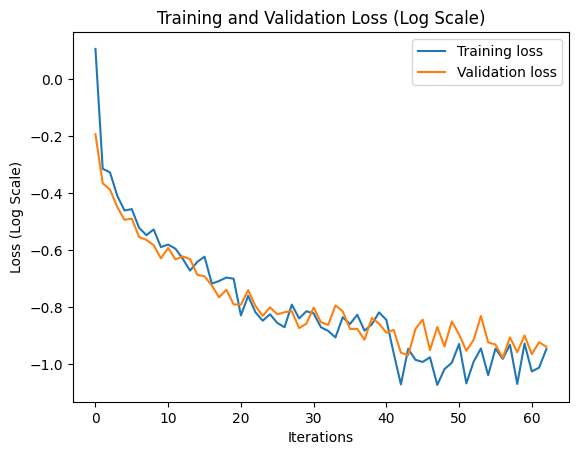

In [14]:
train_losses = []
val_losses = []

train(optim.Adam(model.parameters(), lr=1e-3), epochs=3, train_losses=train_losses, val_losses=val_losses)

[1, 43] avg training loss: 0.057, avg validation loss: 0.085
[1, 86] avg training loss: 0.054, avg validation loss: 0.084
[1, 129] avg training loss: 0.052, avg validation loss: 0.083
[1, 172] avg training loss: 0.057, avg validation loss: 0.080
[1, 215] avg training loss: 0.050, avg validation loss: 0.079
[1, 258] avg training loss: 0.055, avg validation loss: 0.083
[1, 301] avg training loss: 0.044, avg validation loss: 0.079
[1, 344] avg training loss: 0.052, avg validation loss: 0.079
[1, 387] avg training loss: 0.044, avg validation loss: 0.081
[1, 430] avg training loss: 0.050, avg validation loss: 0.081
[1, 473] avg training loss: 0.070, avg validation loss: 0.084
[1, 516] avg training loss: 0.052, avg validation loss: 0.079
[1, 559] avg training loss: 0.058, avg validation loss: 0.081
[1, 602] avg training loss: 0.043, avg validation loss: 0.076
[1, 645] avg training loss: 0.048, avg validation loss: 0.076
[1, 688] avg training loss: 0.050, avg validation loss: 0.078
[1, 731] a

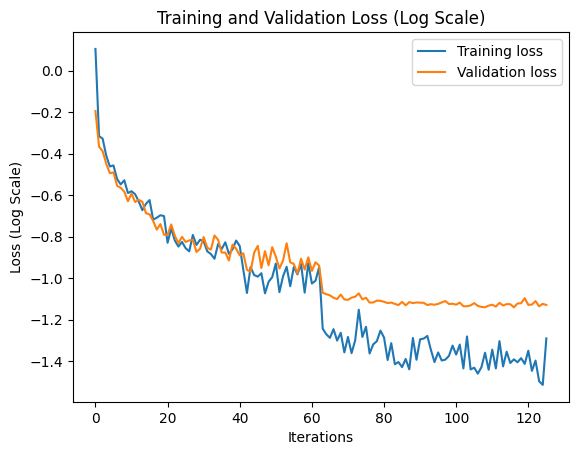

In [15]:
train(optim.Adam(model.parameters(), lr=1e-4), epochs=3, train_losses=train_losses, val_losses=val_losses)

In [16]:
# test loss on the test set; do it in batches to avoid memory issues
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=10000, shuffle=False)
average_test_loss = calculate_average_loss(test_loader, loss_function)
print(f'avg test loss: {average_test_loss:.3f}')

avg test loss: 0.083


---

In [17]:
predictions = predict(X_test, model)
predictions[0:10]

array([5, 7, 5, 1, 1, 9, 2, 9, 3, 3])

In [18]:
y_test[0:10]

tensor([5, 7, 5, 8, 1, 0, 2, 3, 3, 3])

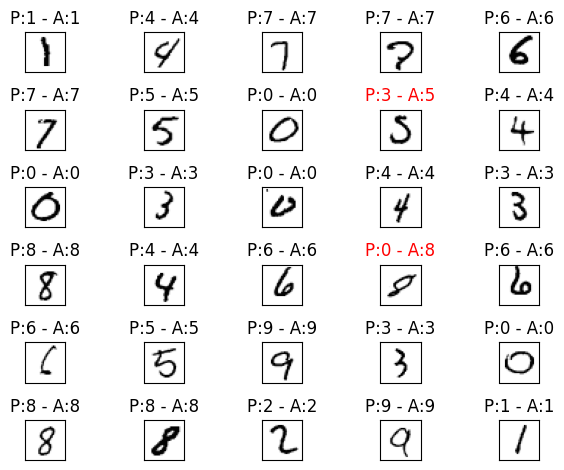

In [19]:
# plot the first 10 test images with their predicted labels
def plot_predictions(num_images: int = 10):
    fig, ax = plt.subplots(nrows=num_images // 5, ncols=5, sharex=True, sharey=True)
    ax = ax.flatten()
    rows = np.random.choice(X_test.shape[0], size=num_images, replace=False)
    for i, row in enumerate(rows):
        img = X_test[row].cpu().numpy().reshape(28, 28)
        ax[i].imshow(img, cmap='Greys')
        title_color = 'red' if predictions[row] != y_test[row] else 'black'
        ax[i].set_title(f'P:{predictions[row]} - A:{y_test[row]}', color=title_color)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()

plot_predictions(num_images=30)

In [20]:
# calculate accuracy metrics on the test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

print(f'Accuracy: {accuracy_score(y_test, predictions):.3f}')
print(f'Precision: {precision_score(y_test, predictions, average="macro"):.3f}')
print(f'Recall: {recall_score(y_test, predictions, average="macro"):.3f}')
print(f'F1: {f1_score(y_test, predictions, average="macro"):.3f}')
print('---')
print(f'Accuracy: {accuracy_score(y_test, predictions):.3f}')
print(f'Precision: {precision_score(y_test, predictions, average="weighted"):.3f}')
print(f'Recall: {recall_score(y_test, predictions, average="weighted"):.3f}')
print(f'F1: {f1_score(y_test, predictions, average="weighted"):.3f}')
print('---')

Accuracy: 0.975
Precision: 0.975
Recall: 0.975
F1: 0.975
---
Accuracy: 0.975
Precision: 0.975
Recall: 0.975
F1: 0.975
---


In [21]:
((y_test == 3)& (predictions == 3)).sum().item()

699

In [22]:
# manually calcualte recall for class 3
_class = 8
true_positives = ((y_test == _class) & (predictions == _class)).sum().item()
false_negatives = ((y_test == _class) & (predictions != _class)).sum().item()
print(f'Recall for class {_class}: {true_positives / (true_positives + false_negatives):.3f}')

Recall for class 8: 0.952


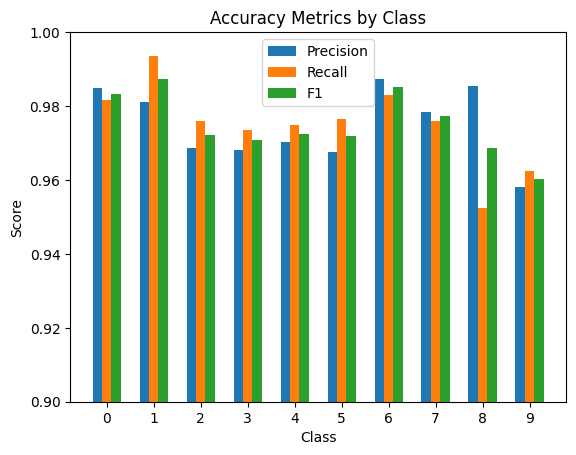

In [23]:
import matplotlib.pyplot as plt

# for each class calculate the accuracy metrics
precision, recall, f1, _ = precision_recall_fscore_support(y_test, predictions)

# create a bar plot
x = range(10)
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x, precision, width, label='Precision')
rects2 = ax.bar([i + width for i in x], recall, width, label='Recall')
rects3 = ax.bar([i + 2 * width for i in x], f1, width, label='F1')

# add labels, title, and legend
ax.set_xlabel('Class')
ax.set_ylabel('Score')
ax.set_title('Accuracy Metrics by Class')
ax.set_xticks([i + width for i in x])
ax.set_xticklabels(range(10))
ax.legend()
# only show y ragen from 0.7 to 1.0
ax.set_ylim([0.9, 1.0])

# display the plot
plt.show()

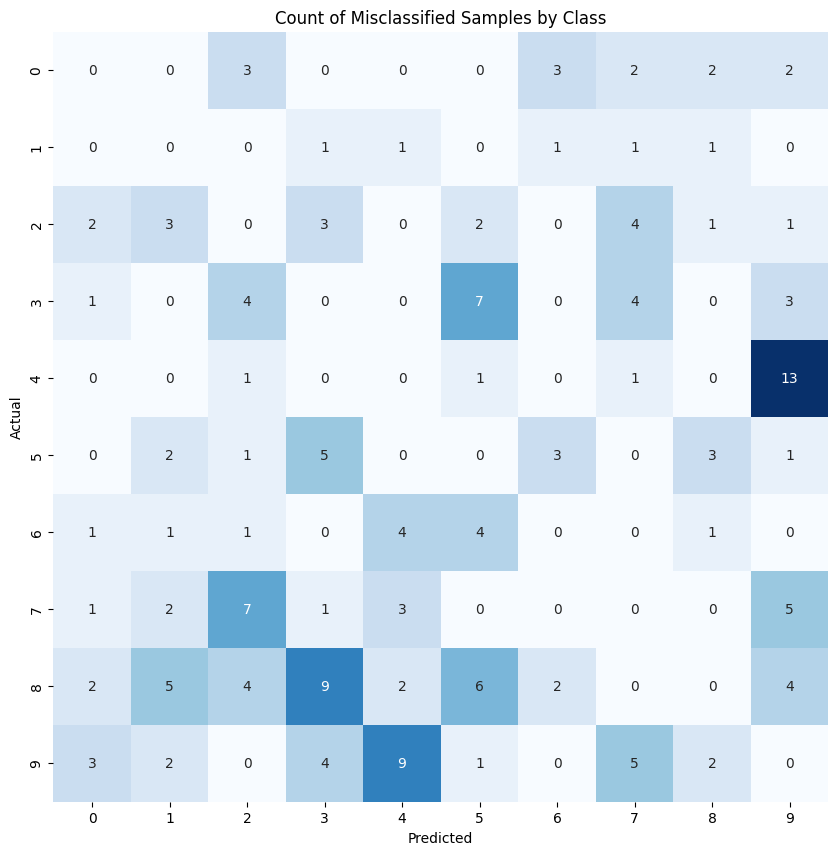

In [25]:
# create a heatmap of misclassified samples
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions)
# remove the diagonal values for better visualization
np.fill_diagonal(cm, 0)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Count of Misclassified Samples by Class')
plt.show()

---